In [1]:
import os
import numpy as np
import yaml
import pprint
import pickle
import utils.signals.gps_l1ca as gps_l1ca
import utils.sample_processing.sample_streaming as sample_streaming
import utils.sample_processing.bpsk_acquisition as bpsk_acquisition
import utils.sample_processing.tracking as tracking
import utils

from scipy.constants import speed_of_light

import matplotlib.pyplot as plt

In [2]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)
raw_collects_dir = os.path.join(data_dir, "raw-collects")
os.makedirs(raw_collects_dir, exist_ok=True)
raw_collect_filenames = sorted(os.listdir(raw_collects_dir))
print(f"Data directory: {data_dir}")
collect_metadata_filepath = os.path.join(raw_collects_dir, "metadata.yml")
with open(collect_metadata_filepath, "r") as f:
    collect_metadata = yaml.safe_load(f)
# pprint.pprint(collect_metadata)
collect_filepaths = {
    collect_id: os.path.join(raw_collects_dir, collect_info["filename"])
    for collect_id, collect_info in collect_metadata["collections"].items()
}

samp_rate = collect_metadata["samp_rate"]
inter_freq_l1_hz = collect_metadata["bands"]["L1"]["inter_freq"]
sample_params_dict = collect_metadata["sample_params"]
sample_params = sample_streaming.SampleParameters.from_dict(sample_params_dict)
print(f"Sample rate: {samp_rate/1e6} MHz")
# pprint.pprint(sample_params_dict)
pprint.pprint(sample_params)

collect_id_list = sorted(collect_filepaths.keys())
print("Available collects:")
for collect_id in collect_id_list:
    print(f"  {collect_id}: {os.path.basename(collect_filepaths[collect_id])}")

collect_id = collect_id_list[0]
collect_filepath = collect_filepaths[collect_id]
print(f"Using collect ID: {collect_id}")
# print(f"  Filepath: {collect_filepath}")

Data directory: /home/brianbw/projects/fall-2025-lectures/local-data
Sample rate: 25.0 MHz
SampleParameters(bit_depth=4,
                 is_complex=True,
                 is_integer=True,
                 is_signed=True,
                 is_i_lsb=True)
Available collects:
  20220513_173218_USRP2: CO_A2_20220513_173218_000211_G1_B1_USRP2.sc4
Using collect ID: 20220513_173218_USRP2


In [3]:
# Load acquisition results from file
acq_results_directory = os.path.join(data_dir, "acquisition-results")
os.makedirs(acq_results_directory, exist_ok=True)
acq_results_version_id = "v1"
acq_results_filepath = os.path.join(
    acq_results_directory, f"{collect_id}.{acq_results_version_id}.pkl"
)
with open(acq_results_filepath, "rb") as f:
    acq_results: dict[str, bpsk_acquisition.AcquisitionResult] = pickle.load(f)

acquired_signal_ids = sorted(list(filter(
    lambda sig_id: acq_results[sig_id].signal_detected, acq_results.keys()
)))
print(f"Acquired signals in collect {collect_id}: ")
print(", ".join(acquired_signal_ids))

Acquired signals in collect 20220513_173218_USRP2: 
G01, G02, G03, G06, G11, G12, G13, G14, G17, G19, G24, G28, G30


In [4]:
buffer_duration_ms = 40
block_duration_ms = 1
buffer_size_samples = int(samp_rate * buffer_duration_ms / 1e3)
block_size_samples = int(samp_rate * block_duration_ms / 1e3)

duration_to_track_ms = 60000
# duration_to_track_ms = 2000
num_blocks_to_track = duration_to_track_ms // block_duration_ms

# tracking_signal_ids = acquired_signal_ids
tracking_signal_ids = ["G01", "G17", "G30"]

GPS_L1_tracking_signal_params = {
    "G{:02d}".format(prn): tracking.TrackingSignalParameters(
        code_seq=1 - 2 * gps_l1ca.get_GPS_L1CA_code_sequence(prn),
        nominal_code_rate_chips_per_sec=gps_l1ca.CODE_RATE,
        carrier_freq_hz=gps_l1ca.CARRIER_FREQ,
    ) for prn in range(1, 33)
}

# Use same tracking loop parameters for all signals
tracking_loop_params = tracking.TrackingLoopParameters(
    DLL_bandwidth_hz=2.0,
    PLL_bandwidth_hz=20.0,
    FLL_bandwidth_hz=50.0,
    update_period_ms=block_duration_ms,
    block_duration_ms=block_duration_ms,
    samp_rate=samp_rate,
    EPL_chip_spacing=0.5
)

tracking_channels = {
    sig_id: tracking.TrackingChannel(
        tracking_loop_params,
        signal_params=GPS_L1_tracking_signal_params[sig_id],
        initial_uptime_seconds=0.0,  # TODO: set proper acquisition epoch uptime
        initial_code_phase_seconds=acq_results[sig_id].acq_code_phase_seconds,
        initial_carrier_phase_cycles=0.0,
        initial_doppler_freq_hz=acq_results[sig_id].acq_doppler_hz,
        output_capacity=num_blocks_to_track,
    )
    for sig_id in tracking_signal_ids
}

In [5]:
with sample_streaming.FileSampleStream(
        collect_filepath,
        sample_params,
        buffer_size_samples,
        block_size_samples,
    ) as sample_stream:

    sample_block_generator = sample_stream.sample_block_generator()
    
    for i_block, sample_block in enumerate(sample_block_generator):
        if i_block >= num_blocks_to_track:
            break
        print(f"\r Processing block {i_block}...", end="")

        uptime_seconds = i_block * block_duration_ms * 1e-3
        
        # Mixdown to baseband
        phi_IF = 2 * np.pi * inter_freq_l1_hz * (uptime_seconds + tracking_loop_params.block_sample_time_arr)
        sample_block *= np.exp(-1j * phi_IF)

        # Track each signal
        for sig_id, channel in tracking_channels.items():
            channel.process_sample_block(uptime_seconds, sample_block)
        

 Processing block 0...

/home/brianbw/projects/fall-2025-lectures/utils/sample_processing/tracking.py:199: RuntimeWarning: divide by zero encountered in scalar divide
  delta_omega = np.angle(prompt / loop_state.last_prompt_corr) / (2e-3 * np.pi * loop_params.block_duration_ms)


 Processing block 59999...

In [6]:
# Save tracking results from file
tracking_results_directory = os.path.join(data_dir, "tracking-results")
os.makedirs(tracking_results_directory, exist_ok=True)
tracking_results_version_id = "vF_1"
tracking_results_filepath = os.path.join(
    tracking_results_directory, f"{collect_id}.{tracking_results_version_id}.pkl"
)
all_tracking_outputs = {
    sig_id: channel.outputs for sig_id, channel in tracking_channels.items()
}
with open(tracking_results_filepath, "wb") as f:
    pickle.dump(tracking_loop_params, f)
    pickle.dump(all_tracking_outputs, f)

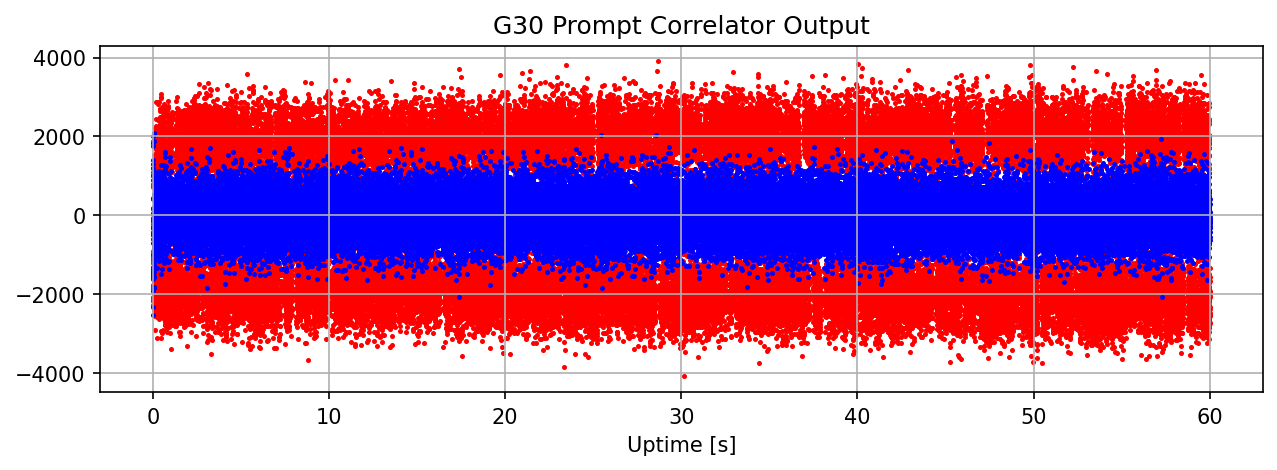

In [7]:
# sig_id = tracking_signal_ids[0]
sig_id = "G30"
signal_outputs = all_tracking_outputs[sig_id]
fig = plt.figure(figsize=(10, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
prompt = signal_outputs.prompt_corr
ax.scatter(signal_outputs.uptime_seconds, prompt.real, s=2, color="r")
ax.scatter(signal_outputs.uptime_seconds, prompt.imag, s=2, color="b")
# prompt = signal_outputs.prompt_corr * np.exp(-1j * 2.0 * np.pi * 530 * signal_outputs.uptime_seconds)
# ax.scatter(signal_outputs.uptime_seconds, prompt.real, s=2, color="r")
# ax.scatter(signal_outputs.uptime_seconds, prompt.imag, s=2, color="b")
# prompt = signal_outputs.prompt_corr
# delta_phase = np.angle(prompt[1:] / prompt[:-1])
# ax.scatter(signal_outputs.uptime_seconds[:-1], delta_phase, s=2, color="g")
# mean_delta_phase = np.mean(delta_phase)
# print(f"Mean delta phase: {mean_delta_phase} rad")
ax.grid()
ax.set_title(f"{sig_id} Prompt Correlator Output")
ax.set_xlabel("Uptime [s]")
plt.show()

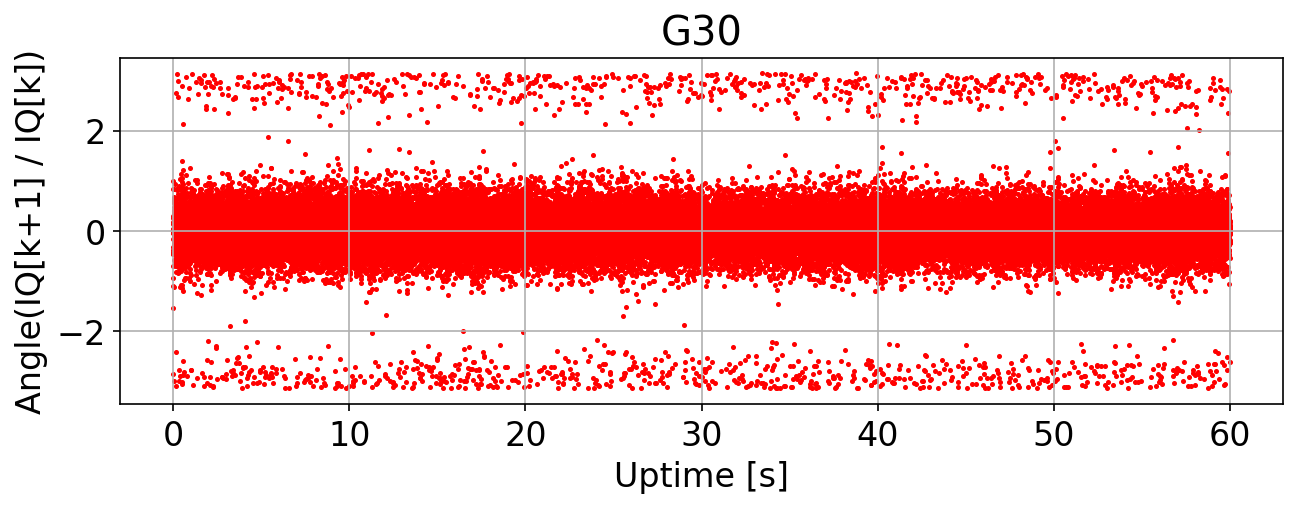

In [8]:
# sig_id = tracking_signal_ids[0]
plt.rcParams.update({"font.size": 16})
sig_id = "G30"
signal_outputs = all_tracking_outputs[sig_id]
fig = plt.figure(figsize=(10, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
prompt = signal_outputs.prompt_corr
# ax.scatter(signal_outputs.uptime_seconds[:-1], np.diff(np.angle(prompt)), s=2, color="r")
# prompt = signal_outputs.prompt_corr * np.exp(-1j * 2.0 * np.pi * 530 * signal_outputs.uptime_seconds)

# ax.scatter(signal_outputs.uptime_seconds, prompt.real, s=2, color="r")
# ax.scatter(signal_outputs.uptime_seconds, prompt.imag, s=2, color="b")
# ax.set_ylabel("Prompt I/Q")

# ax.scatter(signal_outputs.uptime_seconds, np.angle(prompt), s=2, color="r")
# ax.set_ylabel("Angle(Prompt I/Q)")

# ax.scatter(signal_outputs.uptime_seconds[:-1], np.diff(np.angle(prompt)), s=2, color="r")
# ax.set_ylabel("Diff(Angle(Prompt I/Q))")

ax.scatter(
    signal_outputs.uptime_seconds[:-1],
    np.angle(prompt[1:] / prompt[:-1]),
    s=2,
    color="r",
)
ax.set_ylabel("Angle(IQ[k+1] / IQ[k])")

# prompt = signal_outputs.prompt_corr
# delta_phase = np.angle(prompt[1:] / prompt[:-1])
# ax.scatter(signal_outputs.uptime_seconds[:-1], delta_phase, s=2, color="g")
# mean_delta_phase = np.mean(delta_phase)
# print(f"Mean delta phase: {mean_delta_phase} rad")
ax.grid()
ax.set_title(f"{sig_id}")
ax.set_xlabel("Uptime [s]")
plt.show()

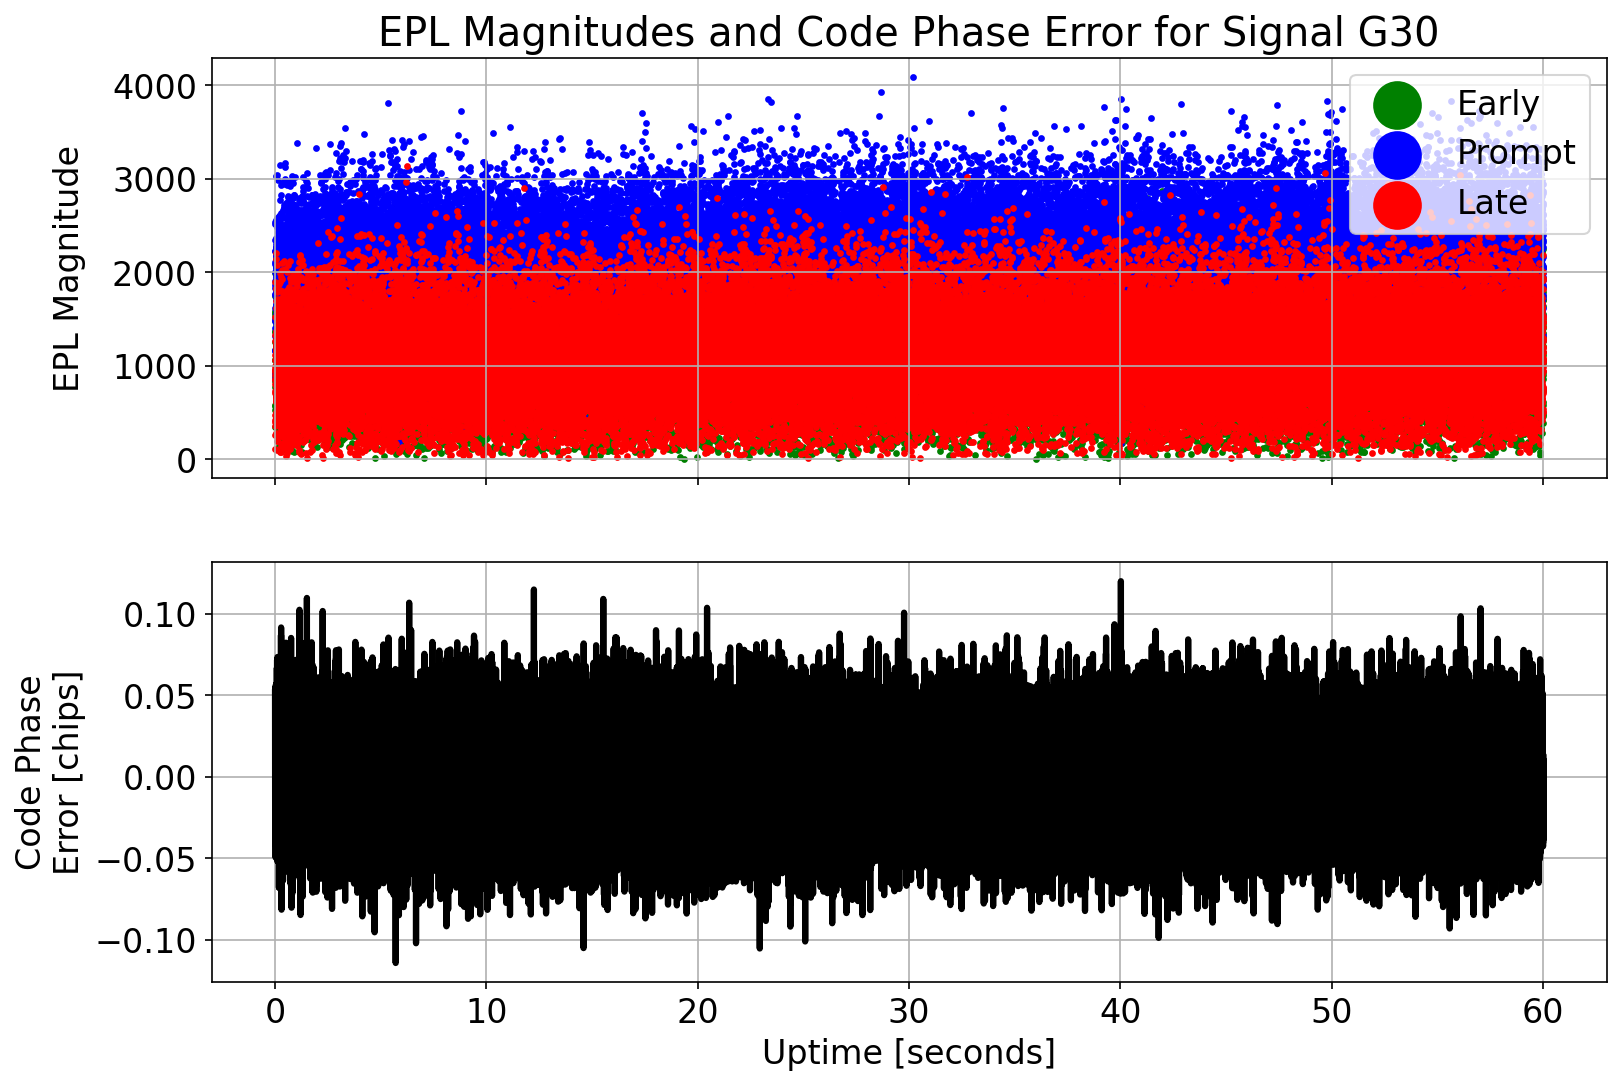

In [12]:
# Plot EPL magnitudes and code error for each tracking version
fig = plt.figure(figsize=(12, 8), dpi=150)
axes = fig.subplots(2, 1, sharex=True)
cmap = plt.get_cmap("viridis")

plot_time = signal_outputs.uptime_seconds
early = signal_outputs.early_corr
prompt = signal_outputs.prompt_corr
late = signal_outputs.late_corr
code_phase_errors_chips = signal_outputs.code_phase_errors_chips

# color = cmap(i / len(plot_tracking_version_ids))

# Plot EPL magnitude
ax = axes[0]
ax.scatter(plot_time, np.abs(early), color="g", s=5)
ax.scatter(plot_time, np.abs(prompt), color="b", s=5)
ax.scatter(plot_time, np.abs(late), color="r", s=5)
ax.set_ylabel("EPL Magnitude")
ax.set_title(f"EPL Magnitudes and Code Phase Error for Signal {sig_id}")
ax.legend(["Early", "Prompt", "Late"], markerscale=10, loc="upper right")

# Plot code phase error
ax = axes[1]
ax.plot(plot_time, code_phase_errors_chips, color="k", lw=3)
ax.set_ylabel("Code Phase\nError [chips]")
ax.set_xlabel("Uptime [seconds]")
# ax.set_xlim(0, 1)
for ax in axes:
    ax.grid()
fig.align_labels()
plt.show()

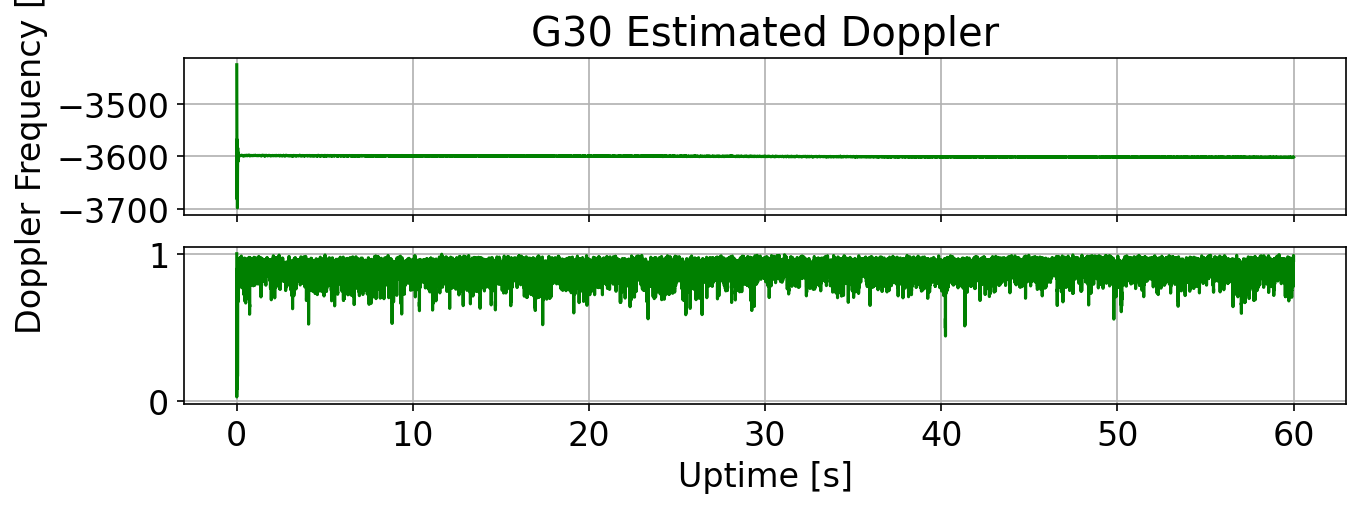

In [13]:
fig = plt.figure(figsize=(10, 3), dpi=150)
axes = fig.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(signal_outputs.uptime_seconds, signal_outputs.doppler_freq_hz, color="g")
ax.grid()
ax.set_title(f"{sig_id} Estimated Doppler")
ax.set_ylabel("Doppler Frequency [Hz]")

ax = axes[1]
ax.plot(signal_outputs.uptime_seconds, signal_outputs.prompt_corr_circ_length, color="g")
ax.grid()
ax.set_xlabel("Uptime [s]")
plt.show()

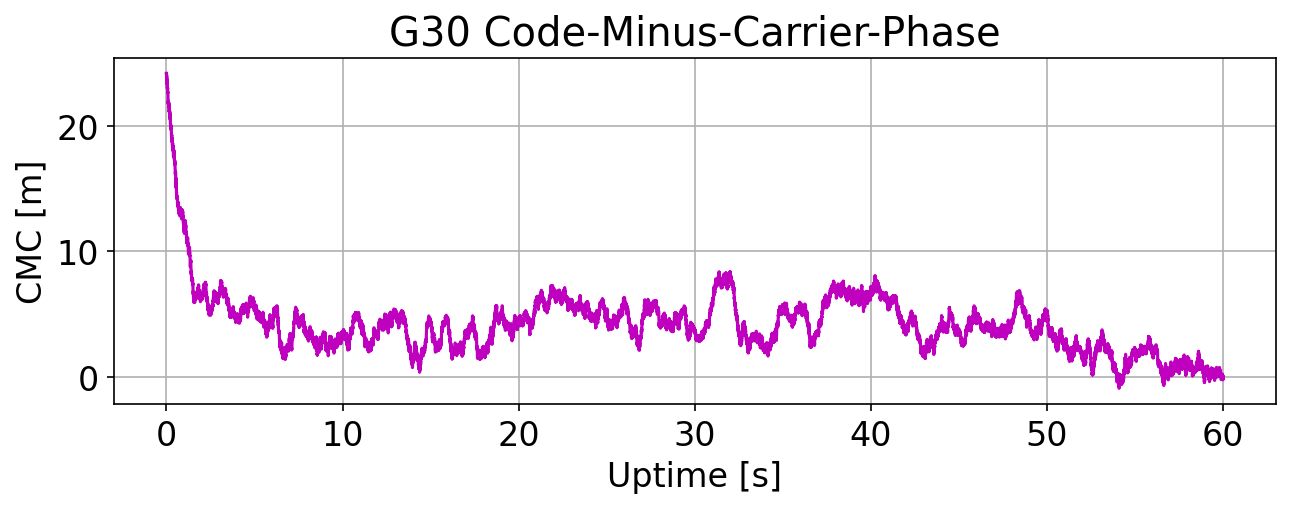

In [14]:
fig = plt.figure(figsize=(10, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
code_delay_seconds = signal_outputs.uptime_seconds - signal_outputs.code_phase_seconds
code_delay_meters = code_delay_seconds * speed_of_light
adr_meters = -signal_outputs.carr_phase_cycles * (
    speed_of_light / gps_l1ca.CARRIER_FREQ
)
code_minus_carr_meters = code_delay_meters - adr_meters
code_minus_carr_meters -= np.mean(code_minus_carr_meters[-100:])
# ax.plot(signal_outputs.uptime_seconds, code_delay_seconds, color="m")  # convert to ms
ax.plot(signal_outputs.uptime_seconds, code_minus_carr_meters, color="m")  # convert to ms
ax.grid()
ax.set_title(f"{sig_id} Code-Minus-Carrier-Phase")
ax.set_xlabel("Uptime [s]")
ax.set_ylabel("CMC [m]")
plt.show()